In [1]:
import ee
import geemap
from geemap import chart

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWg0Z-_w1ylvHQ4-HtzJmf5xe8q1mmsSIYp0nO4DYPUWNUtdZEw-7io

Successfully saved authorization token.


In [51]:
javascript_code = """
// BSI
var bsi = composite.expression(
      '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
        'X': composite.select('SR_B6'), //swir1
        'Y': composite.select('SR_B4'),  //red
        'A': composite.select('SR_B5'), // nir
        'B': composite.select('SR_B2'), // blue
  });
  
Map.addLayer(bsi, {min: 0, max: 1, palette: ['white', '#7a5230']}, 'BSI 1');
"""

In [52]:
geemap.js_snippet_to_py(javascript_code)

In [51]:
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
activeMines = ee.FeatureCollection("users/raymondeah/cod_mines_curated_all_opendata_p_ipis")
points = ee.Geometry.MultiPoint(
        [[29.58905590753292, 3.1265733505900184],
         [29.783181537630476, 3.1489109666499777],
         [30.305007154636336, 1.7496889115779437]])

roi1 = ee.Geometry.Polygon(
        [[[29.554129272985683, 3.1591674847348235],
          [29.554129272985683, 3.092319151883147],
          [29.625197083044277, 3.092319151883147],
          [29.625197083044277, 3.1591674847348235]]])

roi2 = ee.Geometry.Polygon(
        [[[29.76168993261876, 3.1680250077194825],
          [29.76168993261876, 3.1272312365091772],
          [29.803832800660754, 3.1272312365091772],
          [29.803832800660754, 3.1680250077194825]]])

roi3 = ee.Geometry.Polygon(
        [[[30.246670960050185, 1.7911944738716732],
          [30.246670960050185, 1.7103797163160706],
          [30.356362579923232, 1.7103797163160706],
          [30.356362579923232, 1.7911944738716732]]])

tailing = ee.Geometry.Polygon(
        [[[29.577997971250795, 3.125143502676581],
          [29.577997971250795, 3.1232151823991616],
          [29.581431198789858, 3.1232151823991616],
          [29.581431198789858, 3.125143502676581]]])

tailing2 = ee.Geometry.Polygon(
        [[[29.5953837934208, 3.1339441362673477],
          [29.5953837934208, 3.1269165220396835],
          [29.604353100366602, 3.1269165220396835],
          [29.604353100366602, 3.1339441362673477]]])

mine_only = ee.Geometry.Polygon(
        [[[29.56317071981647, 3.1242864718794814],
          [29.56317071981647, 3.1036746708754634],
          [29.575573254301332, 3.1036746708754634],
          [29.575573254301332, 3.1242864718794814]]])

In [52]:
rgbVis = {
    'min': 8097.96,
    'max': 12128.04,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']
}

vigsVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']
}

ndviVis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'green']
}

ironVis = {
    'min': 1.030170142666699,
    'max': 1.4796675821766498,
    'palette': ['white', 'gray']
}

clayVis = {
    'min': 1.1333754972833363,
    'max': 1.3931124450708396,
    'palette': ['white', 'brown']
}

ndmiVis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'blue']
}

bsiVis = {
    'min': -0.11390094234742729, 
    'max': 0.12724605991882074, 
    'palette': ['white', '#7a5230']
}

g_nirVis = {
    'min': -0.3899937702037737,
    'max': -0.03382993411150684,
    'palette': ['white', 'red']
}

In [53]:
def create_median_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = ls8 \
            .filter(ee.Filter.bounds(geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .filter(ee.Filter.lt('CLOUD_COVER', 15)) \
            .select('SR_B.*') \

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

In [54]:
def add_median_composites(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
        
    return Map

In [55]:
def create_ndvi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
        Map.addLayer(ndvi, ndviVis, 'NDVI ' + str(year))
        
    return Map

In [56]:
def create_iron_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        iron = image.select('SR_B4').divide(image.select('SR_B2'))
        #iron = image.normalizedDifference(['SR_B4', 'SR_B2'])
        Map.addLayer(iron, ironVis, 'Iron Concentration ' + str(year))
        
    return Map

In [57]:
def create_clay_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        clay = image.select('SR_B6').divide(image.select('SR_B7'))
        Map.addLayer(clay, clayVis, 'Clay Concentration ' + str(year))
        
    return Map

In [58]:
def create_ndmi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        ndmi = image.normalizedDifference(['SR_B5', 'SR_B6'])
        Map.addLayer(ndmi, ndmiVis, 'NDMI ' + str(year))
        
    return Map

In [59]:
def create_vigs_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        g_r = image.normalizedDifference(['SR_B3', 'SR_B4'])
        nir_r = image.normalizedDifference(['SR_B5', 'SR_B4'])
        nir_swir1 = image.normalizedDifference(['SR_B5', 'SR_B6'])
        nir_swir2 = image.normalizedDifference(['SR_B5', 'SR_B7'])
        
        vigs = g_r.add(nir_r.multiply(0.5)) \
            .add(nir_swir1.multiply(1.5)) \
            .add(nir_swir2.multiply(1.5))
        
        Map.addLayer(vigs, vigsVis, 'VIGS ' + str(year))
        
    return Map

In [60]:
def create_bsi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        # BSI
        bsi = image.expression(
            '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
            'X': image.select('SR_B6'), #swir1
            'Y': image.select('SR_B4'),  #red
            'A': image.select('SR_B5'), # nir
            'B': image.select('SR_B2'), # blue
            })

        Map.addLayer(bsi, bsiVis, 'BSI ' + str(year))
        
    return Map

In [61]:
def create_g_nir_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        g_nir = image.normalizedDifference(['SR_B3', 'SR_B5'])
        Map.addLayer(g_nir, g_nirVis, 'G/NIR ' + str(year))
        
    return Map

## Region 1

### Median Composites

In [62]:
images = create_median_composites(roi1, 2014, 2020)
Map = add_median_composites(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### NDVI

In [63]:
Map = create_ndvi_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### NDMI

In [64]:
Map = create_ndmi_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### Iron

In [65]:
Map = create_iron_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### Clay

In [66]:
Map = create_clay_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### VIGS

In [67]:
Map = create_vigs_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### BSI

In [68]:
Map = create_bsi_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### New Index (G/NIR)

In [69]:
Map = create_g_nir_layers(images, roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

In [74]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 100
    })
    
    properties = {
        'Year': image.get('system:index'),
        'NDVI': stats.get('ndvi'),
        'VIGS': stats.get('vigs'),
        'NDMI': stats.get('ndmi'),
        'BSI': stats.get('bsi'),
        'Iron': stats.get('iron'),
        'Clay': stats.get('clay'),
        #'G/NIR': stats.get('g_nir')
    }
    
    return ee.Feature(None, properties)

In [75]:
def add_all_bands(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')
    iron = image.select('SR_B4').divide(image.select('SR_B2')).rename('iron')
    #iron = image.normalizedDifference(['SR_B4', 'SR_B2']).rename('iron')
    clay = image.select('SR_B6').divide(image.select('SR_B7')).rename('clay')
    #clay = image.normalizedDifference(['SR_B6', 'SR_B7']).rename('clay')
    ndmi = image.normalizedDifference(['SR_B5', 'SR_B6']).rename('ndmi')
    
    g_r = image.normalizedDifference(['SR_B3', 'SR_B4'])
    nir_r = image.normalizedDifference(['SR_B5', 'SR_B4'])
    nir_swir1 = image.normalizedDifference(['SR_B5', 'SR_B6'])
    nir_swir2 = image.normalizedDifference(['SR_B5', 'SR_B7'])
        
    vigs = g_r.add(nir_r.multiply(0.5)) \
        .add(nir_swir1.multiply(1.5)) \
        .add(nir_swir2.multiply(1.5)).rename('vigs')
    
    bsi = image.expression(
            '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
            'X': image.select('SR_B6'), #swir1
            'Y': image.select('SR_B4'),  #red
            'A': image.select('SR_B5'), # nir
            'B': image.select('SR_B2'), # blue
            }).rename('bsi')
    
   #g_nir = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('g_nir')
    
    return image.addBands([ndvi, iron, clay, ndmi, vigs, bsi])

In [76]:
images1 = ee.ImageCollection(create_median_composites(roi1, 2014, 2020))
with_bands1 = images1.map(add_all_bands)
data1 = ee.FeatureCollection(with_bands1.map(extract_data))
df1 = geemap.ee_to_pandas(data1)
images1 = create_median_composites(roi1, 2014, 2020)

t = ee.ImageCollection(create_median_composites(tailing, 2014, 2020))
tb = t.map(add_all_bands)
data2 = ee.FeatureCollection(tb.map(extract_data))
df2 = geemap.ee_to_pandas(data2)
t = create_median_composites(tailing, 2014, 2020)

m = ee.ImageCollection(create_median_composites(mine_only, 2014, 2020))
mb = m.map(add_all_bands)
data3 = ee.FeatureCollection(mb.map(extract_data))
df3 = geemap.ee_to_pandas(data3)
m = create_median_composites(mine_only, 2014, 2020)

#images2 = ee.ImageCollection(create_median_composites(roi2, 2016, 2020))
#with_bands2 = images2.map(add_all_bands)
#data2 = ee.FeatureCollection(with_bands2.map(extract_data))
#df2 = geemap.ee_to_pandas(data2)

#images3 = ee.ImageCollection(create_median_composites(roi3, 2016, 2020))
#with_bands3 = images3.map(add_all_bands)
#data3 = ee.FeatureCollection(with_bands3.map(extract_data))
#df3 = geemap.ee_to_pandas(data3)

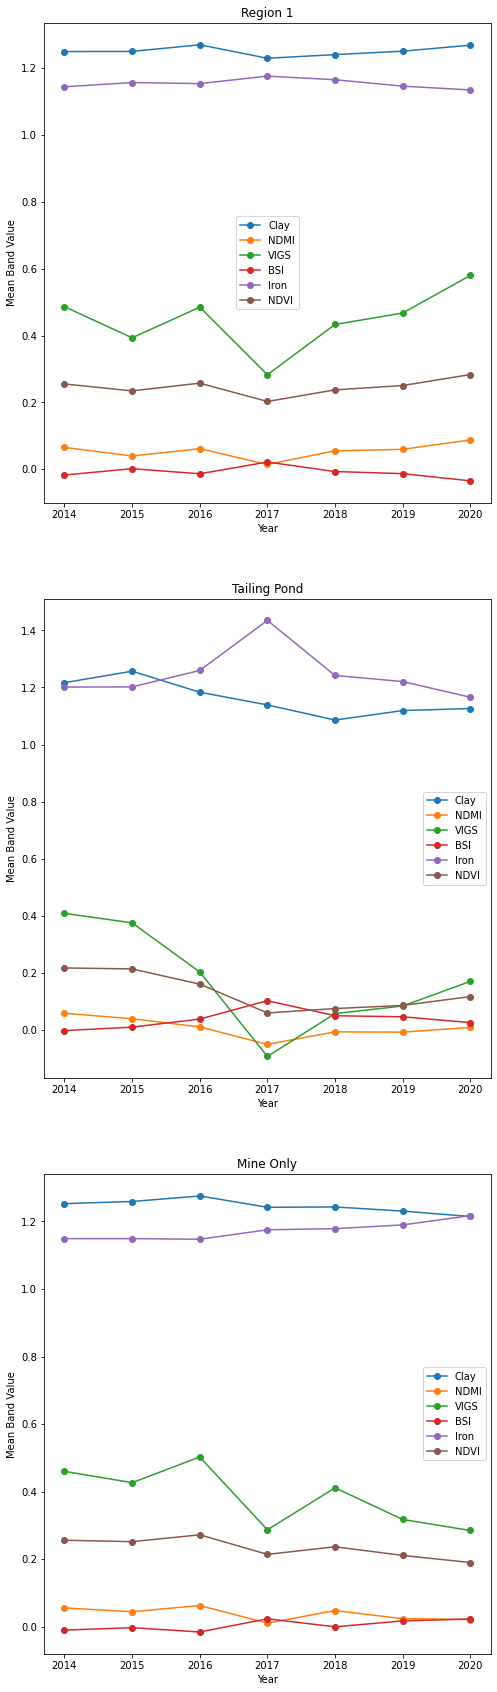

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(8, 30)

xticks = [t[1] for t in images1]
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6], xticks)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6], xticks)
ax3.set_xticks([0, 1, 2, 3, 4, 5, 6], xticks)

df1.plot(ax=ax1,
       title = 'Region 1',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

df2.plot(ax=ax2,
        title = 'Tailing Pond',
        xlabel='Year',
        ylabel='Mean Band Value',
        marker='o')

df3.plot(ax=ax3,
        title = 'Mine Only',
        xlabel='Year',
        ylabel='Mean Band Value',
        marker='o')

plt.show()